In [4]:
import sys
sys.path.append('../')

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_irl_one_spin"

with open(os.path.join(DATA_PATH, "transforms.json"), "r") as f:
    transforms = json.load(f)

[[-177.98673848   -2.64073892   30.00347268]
 [-177.32015027   -2.11295495   12.10077036]
 [-177.31712515   -2.10909727   12.01822747]
 [-177.36564624   -2.17455195   13.31595155]
 [-177.37825514   -2.19077405   13.66107346]
 [-176.9623353    -1.88832712   -1.03023224]
 [-176.64861314   -1.60582982   -6.15704185]
 [-176.19017112   -1.03771094  -16.00273298]
 [-176.19117059   -1.04288274  -15.92799529]
 [-176.06854565   -0.57032108  -23.09878936]]


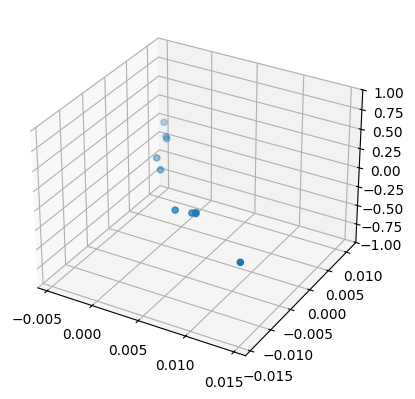

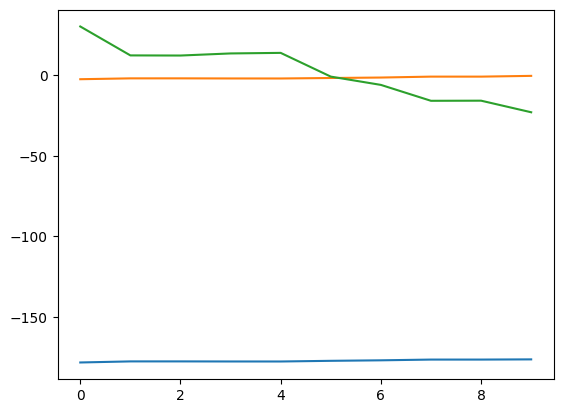

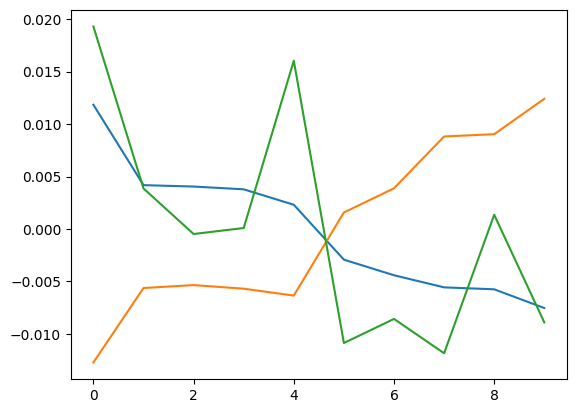

In [5]:
OPENGL = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

points = []
euler_angle = []
for frame in transforms["frames"]:
    tf = np.array(frame["transform_matrix"])
    #tf = np.dot(OPENGL,tf)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))
    
points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
#Set z-axis
ax.set_zlim(-1, 1)

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()

In [6]:
with open(os.path.join(DATA_PATH, "ground_truth.json"), "r") as f:
    ground_truth = json.load(f)
    
#transforms["frames"] = rotate_best_fit_plane(transforms["frames"])

ground_truth["frames"] = ground_truth["frames"][0:len(transforms["frames"])]

points = []
euler_angle = []
for frame in ground_truth["frames"]:
    tf = np.array(frame["transform_matrix"])
    #tf = np.dot(OPENGL,tf)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))
    
points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
#Set z-axis
#ax.set_zlim(-1, 1)

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/dust3r/masked_dust3r/data/jackal_irl_one_spin/ground_truth.json'